**Building a Simple Regression Model**

In [1]:
!pip install yellowbrick rdkit-pypi PyTDC lightgbm

In [1]:
import pandas as pd #data manipulation
from tqdm.auto import tqdm #progress bar
from rdkit import Chem #Chemistry
from rdkit.Chem import rdMolDescriptors #molecular descriptors
import numpy as np #matrix algebra
from lightgbm import LGBMRegressor, plot_importance #LightGBM models
from sklearn.model_selection import train_test_split #ML training
from sklearn.metrics import r2_score, mean_squared_error #ML stats
import seaborn as sns #Plotting
from yellowbrick.regressor import prediction_error, ResidualsPlot
from tdc.single_pred import ADME

Set plot fonts, etc. 

In [2]:
sns.set_context('talk')

Enable Pandas progress_apply

In [3]:
tqdm.pandas()

Read the data

In [4]:
data = ADME(name = 'Solubility_AqSolDB')
sol_df = data.get_data()
sol_df.columns = ["Name","SMILES","LogS"]

Found local copy...
Loading...
Done!


Set up property calculations

In [5]:
property_names = list(rdMolDescriptors.Properties.GetAvailableProperties())
property_getter = rdMolDescriptors.Properties(property_names)

Define a function to calculate properties from SMILES

In [6]:
def smi2props(smi):
    mol = Chem.MolFromSmiles(smi)
    props = None
    if mol:
        Chem.DeleteSubstructs(mol, Chem.MolFromSmarts("[#1X0]"))
        props = np.array(property_getter.ComputeProperties(mol))
    return props

Add the properties to the dataframe

In [7]:
sol_df['props'] = sol_df.SMILES.progress_apply(smi2props)

  0%|          | 0/9982 [00:00<?, ?it/s]

RDKit WARNING: [20:07:09] WARNING: not removing hydrogen atom without neighbors
[20:07:09] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [20:07:09] WARNING: not removing hydrogen atom without neighbors
[20:07:09] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [20:07:09] WARNING: not removing hydrogen atom without neighbors
[20:07:09] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [20:07:10] WARNING: not removing hydrogen atom without neighbors
[20:07:10] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [20:07:10] WARNING: not removing hydrogen atom without neighbors
[20:07:10] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [20:07:10] WARNING: not removing hydrogen atom without neighbors
[20:07:10] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [20:07:10] WARNING: not removing hydrogen atom without neighbors
[20:07:10] WARNING: not removing hydrogen atom wit

RDKit WARNING: [20:07:19] WARNING: not removing hydrogen atom without neighbors
[20:07:19] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [20:07:20] WARNING: not removing hydrogen atom without neighbors
[20:07:20] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [20:07:20] WARNING: not removing hydrogen atom without neighbors
[20:07:20] WARNING: not removing hydrogen atom without neighbors


Put the descriptors into individual columns

In [8]:
sol_df[property_names] = sol_df['props'].to_list()

Split the data into training and test sets

In [9]:
train, test = train_test_split(sol_df)

Define x and y variables for model building

In [10]:
train_X = train[property_names]
train_y = train.LogS
test_X = test[property_names]
test_y = test.LogS

Create a LightGBM Repressor

In [11]:
lgbm = LGBMRegressor()

Fit the model

In [12]:
lgbm.fit(train_X, train_y)

LGBMRegressor()

Make the prediction

In [13]:
pred = lgbm.predict(test_X)

Plot predicted vs experimental solubility

[Text(0, 0.5, 'Predicted LogS')]

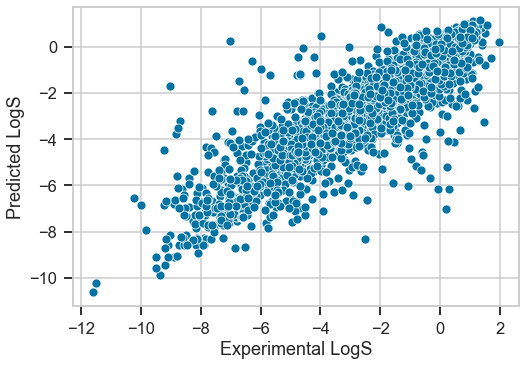

In [14]:
ax = sns.scatterplot(x=test_y,y=pred)
ax.set(xlabel="Experimental LogS")
ax.set(ylabel="Predicted LogS")

Make the same plot with Seaborn's **regplot**

[Text(0, 0.5, 'Predicted LogS')]

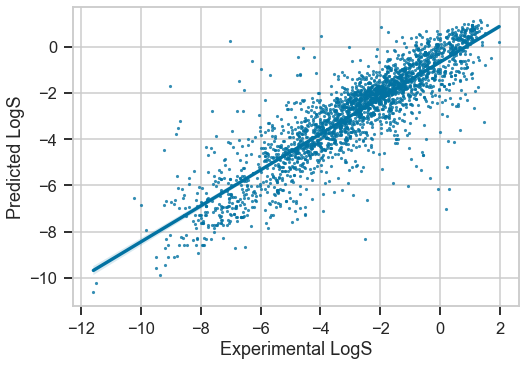

In [15]:
ax = sns.regplot(x=test_y,y=pred,scatter_kws={'s':10})
ax.set(xlabel="Experimental LogS")
ax.set(ylabel="Predicted LogS")

Calculate the coeffcient of determination (R<sup>2</sup>)

In [16]:
r2_score(test_y,pred)

0.7584700736747634

Calculate the RMS error

In [17]:
mean_squared_error(test_y,pred,squared=False)

1.1563810836247332

LightGBM provides an easy means of identifying important variables

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

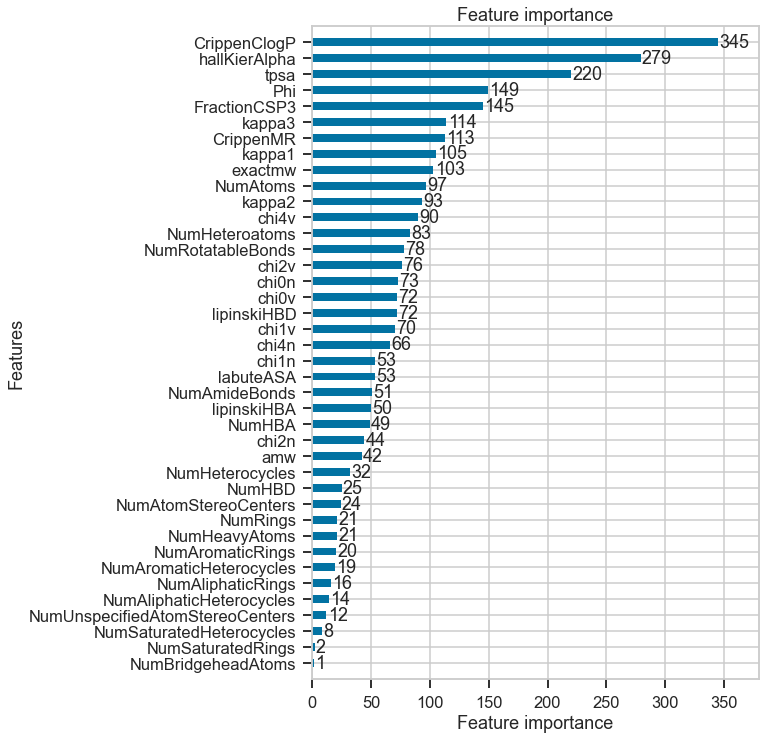

In [18]:
plot_importance(lgbm,figsize=(8,12),height=0.5)

The [Yellowbrick](https://www.scikit-yb.org/en/latest/index.html) Python library provides some useful diagnostic plots for ML models.

In [21]:
lgbm = LGBMRegressor()
train, test = train_test_split(sol_df)
train_X = train[property_names]
train_y = train.LogS
test_X = test[property_names]
test_y = test.LogS

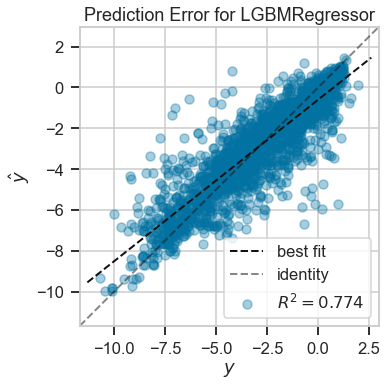

In [22]:
visualizer = prediction_error(lgbm, train_X, train_y, test_X, test_y,alpha=0.35)

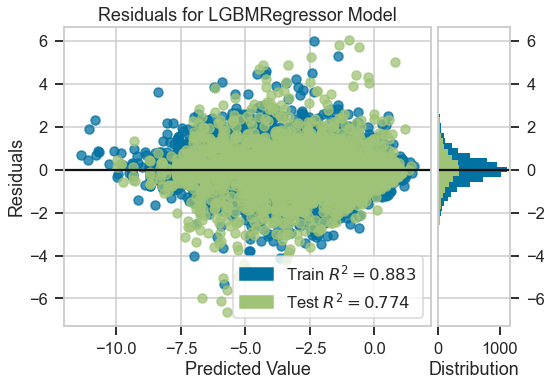

In [23]:
visualizer = ResidualsPlot(lgbm)
visualizer.fit(train_X, train_y)
visualizer.score(test_X, test_y)
visualizer.show();

Run 10 cycles of cross validation on a model

In [26]:
r2_list = []
for i in tqdm(range(0,10)):
    # setup training and test sets
    train, test = train_test_split(sol_df)
    train_X = train[property_names]
    train_y = train.LogS
    test_X = test[property_names]
    test_y = test.LogS
    # create the regressor
    lgbm = LGBMRegressor()
    # train the model
    lgbm.fit(train_X,train_y)
    pred = lgbm.predict(test_X)
    r2 = r2_score(test_y,pred)
    print(r2)
    r2_list.append(r2)

  0%|          | 0/10 [00:00<?, ?it/s]

0.776564458674749
0.7779517473132277
0.7768524022133481
0.7850013099341071
0.7792905924222178
0.7609718236209408
0.7759513403940275
0.7943097687093137
0.7991315552686973
0.8101034503913385


Plot R<sup>2</sup> across the 10 folds as a boxplot

[Text(0.5, 0, 'R$^2$')]

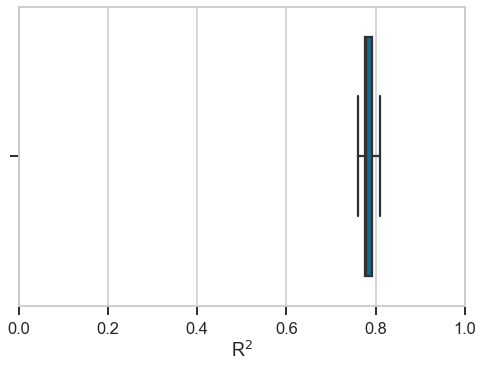

In [27]:
ax = sns.boxplot(x=r2_list)
ax.set(xlim=(0,1))
ax.set(xlabel="R$^2$")